# Raquamaton

### Basic Grid Functions

In [1]:
import math
import time
import drawsvg
import random


In [2]:
#DEFENITIONS
class Bit_Generator:
    def __next__(self):
        return [[random.choice([0,1]) for i in range(0,9)] for j in range(0,5)]

def draw_bits(example_bits, marked=None, mark_colour=None):
    """Draw the bits as a shaded grid, marking special points"""
    # Understanding this code is not important to the tutorial
    square_size = 20 # in pixels
    drawing = drawsvg.Drawing(square_size*len(example_bits[0]), square_size*len(example_bits))
    for row in range(len(example_bits)):
        for index, bit in enumerate(example_bits[row]):
            colour = '#00e000' if bit else '#e10000'
            rect = drawsvg.Rectangle(index*square_size,(len(example_bits)-1-row)*square_size,square_size,square_size, fill=colour)
            drawing.append(rect)
    if marked is None:
        marked = []
    for index, mark in enumerate(marked):
        # Mark each coordinate in the list `marked`
        x = mark[0]
        y = mark[1]
        colour = "#11f" if mark_colour is None else mark_colour
        circle = drawsvg.Circle((x+0.5)*square_size,(len(example_bits)-0.5-y)*square_size,square_size/6, fill=colour)
        drawing.append(circle)
    return drawing

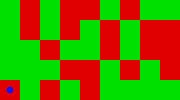

In [3]:
#Initiation
BG = Bit_Generator()
example_bits = next(BG)
example_bits
draw_bits(example_bits,[[0,0]])

In [4]:

len(example_bits)


5

In [6]:
def draw_neighbours(bits, point):
    """Draw the grid of bits and mark all cells surrounding and including the named point."""
    neighs = [[x,y] for x in range(point[0]-1,point[0]+2) for y in range(point[1]-1,point[1]+2)]
    return draw_bits(bits, neighs)

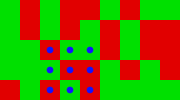

In [7]:
draw_neighbours(example_bits,[3,1])

In [34]:
def lookup(bit_grid, coordinates):
    #periodic boundary conditions
    i = coordinates[1]%len(bit_grid)
    j = coordinates[0]%len(bit_grid[i])
    return bit_grid[i][j]

def neighbours_cross(bit_grid, coordinate):
    """For the specified point in the grid return a dictionary of names to cell values.
    
    The names for the neighbours are from the CAMUS specification.
    """
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = {"N":lookup(bit_grid,[x_mid,y_mid+1]),"E":lookup(bit_grid,[x_mid+1,y_mid]),
               "S":lookup(bit_grid,[x_mid,y_mid-1]),"W":lookup(bit_grid,[x_mid-1,y_mid])
              }
    return ordered

def neighbours_diag(bit_grid, coordinate):
    """For the specified point in the grid return a dictionary of names to cell values.
    
    The names for the neighbours are from the CAMUS specification.
    """
    x_mid = coordinate[0]
    y_mid = coordinate[1]
    ordered = {"NE":lookup(bit_grid,[x_mid+1,y_mid+1]),"SE":lookup(bit_grid,[x_mid+1,y_mid-1]),
               "SW":lookup(bit_grid,[x_mid-1,y_mid-1]),"NW":lookup(bit_grid,[x_mid-1,y_mid+1])
              }
    return ordered

In [9]:
neighbours_cross(example_bits,[5,1])

{'N': 0, 'E': 0, 'S': 1, 'W': 0}

In [10]:
s = list(neighbours_diag(example_bits,[2,1]).values())
s

[1, 1, 1, 1]

In [57]:
def bit_seq_to_int(bits):
    return int("".join(map(str, bits)),2)


In [12]:
bit_seq_to_int(s)

15

### Tesselation + Quantum Circuit

In [13]:
import qiskit
import pqca

In [383]:
size = [12,4] #[9,6]
initial_state = [0]*size[0]*size[1] 

In [384]:
tes_1 = pqca.tessellation.n_dimensional(size,[3,2]) 
tes_2 = pqca.tessellation.n_dimensional(size,[6,1]) 

In [380]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
qs1 = 6
qc1 = qiskit.QuantumCircuit(qs1)
for i in range(qs1):
    qc1.h(i)

qc1.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ H ├
     └───┘

In [18]:
qs2 = 6
qc2 = qiskit.QuantumCircuit(qs2)
#two_qubit_circuit.h(0)
qc2.cx(0,1)
#two_qubit_circuit.h(3)
qc2.cz(3,2)
qc2.mcx([5,2],4)


qc2.draw()

q_0: ──■───────
     ┌─┴─┐     
q_1: ┤ X ├─────
     └───┘     
q_2: ──■────■──
       │    │  
q_3: ──■────┼──
          ┌─┴─┐
q_4: ─────┤ X ├
          └─┬─┘
q_5: ───────■──

In [385]:
update_frame_1 = pqca.UpdateFrame(tes_1, qiskit_circuit=qc1)
update_frame_2 = pqca.UpdateFrame(tes_2,  qiskit_circuit=qc2)

In [386]:
automaton = pqca.Automaton(initial_state, [update_frame_1, update_frame_2], pqca.backend.qiskit())

In [387]:
automaton.update_circuit.draw()

┌───┐                                        
 q_0: ┤ H ├──■─────────────────────────────────────
      ├───┤  │                                     
 q_1: ┤ H ├──┼────■────────────────────────────────
      ├───┤  │    │                                
 q_2: ┤ H ├──┼────┼────■───────────────────────────
      ├───┤  │    │    │                           
 q_3: ┤ H ├──┼────┼────┼────■──────────────────────
      ├───┤┌─┴─┐  │    │    │                      
 q_4: ┤ H ├┤ X ├──┼────┼────┼──────────────────────
      ├───┤└───┘┌─┴─┐  │    │                      
 q_5: ┤ H ├─────┤ X ├──┼────┼──────────────────────
      ├───┤     └───┘┌─┴─┐  │                      
 q_6: ┤ H ├──────────┤ X ├──┼──────────────────────
      ├───┤          └───┘┌─┴─┐                    
 q_7: ┤ H ├───────────────┤ X ├────────────────────
      ├───┤               └───┘                    
 q_8: ┤ H ├──■───────────────────■─────────────────
      ├───┤  │                   │                 
 q_9: ┤ H ├──┼────■──────────────┼────■────────────
      ├───┤  │    │              │    │            
q_10: ┤ H ├──┼────┼────■─────────┼────┼────■───────
      ├───┤  │    │    │         │    │    │       
q_11: ┤ H ├──┼────┼────┼────■────┼────┼────┼────■──
      ├───┤  │    │    │    │    │    │    │    │  
q_12: ┤ H ├──■────┼────┼────┼────┼────┼────┼────┼──
      ├───┤       │    │    │    │    │    │    │  
q_13: ┤ H ├───────■────┼────┼────┼────┼────┼────┼──
      ├───┤            │    │    │    │    │    │  
q_14: ┤ H ├────────────■────┼────┼────┼────┼────┼──
      ├───┤                 │    │    │    │    │  
q_15: ┤ H ├─────────────────■────┼────┼────┼────┼──
      ├───┤                    ┌─┴─┐  │    │    │  
q_16: ┤ H ├────────────────────┤ X ├──┼────┼────┼──
      ├───┤                    └─┬─┘┌─┴─┐  │    │  
q_17: ┤ H ├──────────────────────┼──┤ X ├──┼────┼──
      ├───┤                      │  └─┬─┘┌─┴─┐  │  
q_18: ┤ H ├──────────────────────┼────┼──┤ X ├──┼──
      ├───┤                      │    │  └─┬─┘┌─┴─┐
q_19: ┤ H ├──────────────────────┼────┼────┼──┤ X ├
      ├───┤                      │    │    │  └─┬─┘
q_20: ┤ H ├──────────────────────■────┼────┼────┼──
      ├───┤                           │    │    │  
q_21: ┤ H ├───────────────────────────■────┼────┼──
      ├───┤                                │    │  
q_22: ┤ H ├────────────────────────────────■────┼──
      ├───┤                                     │  
q_23: ┤ H ├─────────────────────────────────────■──
      ├───┤                                        
q_24: ┤ H ├──■─────────────────────────────────────
      ├───┤  │                                     
q_25: ┤ H ├──┼────■────────────────────────────────
      ├───┤  │    │                                
q_26: ┤ H ├──┼────┼────■───────────────────────────
      ├───┤  │    │    │                           
q_27: ┤ H ├──┼────┼────┼────■──────────────────────
      ├───┤┌─┴─┐  │    │    │                      
q_28: ┤ H ├┤ X ├──┼────┼────┼──────────────────────
      ├───┤└───┘┌─┴─┐  │    │                      
q_29: ┤ H ├─────┤ X ├──┼────┼──────────────────────
      ├───┤     └───┘┌─┴─┐  │                      
q_30: ┤ H ├──────────┤ X ├──┼──────────────────────
      ├───┤          └───┘┌─┴─┐                    
q_31: ┤ H ├───────────────┤ X ├────────────────────
      ├───┤               └───┘                    
q_32: ┤ H ├──■───────────────────■─────────────────
      ├───┤  │                   │                 
q_33: ┤ H ├──┼────■──────────────┼────■────────────
      ├───┤  │    │              │    │            
q_34: ┤ H ├──┼────┼────■─────────┼────┼────■───────
      ├───┤  │    │    │         │    │    │       
q_35: ┤ H ├──┼────┼────┼────■────┼────┼────┼────■──
      ├───┤  │    │    │    │    │    │    │    │  
q_36: ┤ H ├──■────┼────┼────┼────┼────┼────┼────┼──
      ├───┤       │    │    │    │    │    │    │  
q_37: ┤ H ├───────■────┼────┼────┼────┼────┼────┼──
      ├───┤            │    │    │    │    │    │  
q_

In [23]:
class Qubit_Generator:
    def __next__(self):
        many_bits = next(automaton)
        return [[many_bits[i+j] for j in range(size[0])] for i in range(size[1])]


In [25]:
import ipywidgets
def visualise_next_n_steps(cached_states, n):
    def show_step(iteration):
        return draw_bits(cached_states[iteration])
    return ipywidgets.interact(show_step,iteration=ipywidgets.IntSlider(min=0, max=n-1, step=1, value=0))


In [397]:
#bits = next(QBG)
#bits
reps = 100
QBG = Qubit_Generator()
cached_states = [next(QBG) for _ in range(reps)]
visualise_next_n_steps(cached_states, reps)
pass

interactive(children=(IntSlider(value=0, description='iteration', max=99), Output()), _dom_classes=('widget-in…

### Bit Breakdown
Currently:
 - 'Tabla drums' (4x4)
 - 'Sitar' (5x5)

In [390]:
import numpy as np
def bit_breakdown(bit_grid):
    """Split the large grid into appropriate subgrids."""
    return {"tabla": np.array([row[0:4] for row in bit_grid]),
            "sitar": np.array([row[4:12] for row in bit_grid]),
           # "instruments": [row[5:9] for row in bit_grid],
    }

In [303]:
def criss_cross_int(state):
    #creates new arrays with binary values from neighbours to integer
    wx = len(state)
    wy = len(state[0])
    cross_int = np.zeros((wx,wy))
    diag_int = np.zeros((wx,wy))
    for i in range(wx):
        for j in range(wy):
            cross_int[i,j] = bit_seq_to_int( np.array(list(neighbours_cross(state,[i,j]).values())))
            diag_int[i,j] =  bit_seq_to_int(np.array(list(neighbours_diag(state,[i,j]).values())))
    return {"cross": cross_int, "diag": diag_int}

def criss_cross_sum(state,shift=-1):
    #creates new arrays with summed values from neighbours
    wx = len(state)
    wy = len(state[0])
    cross_sum = np.zeros((wx,wy))
    diag_sum = np.zeros((wx,wy))
    for i in range(wx):
        for j in range(wy):
            cross_sum[i,j] = np.array(list(neighbours_cross(state,[i,j]).values())).sum()+shift
            diag_sum[i,j] =  np.array(list(neighbours_diag(state,[i,j]).values())).sum()+shift
    return {"cross": cross_sum, "diag": diag_sum}

def grid_to_seq(grid,len = 16, mod=20e3,shift = 0): 
    seq = np.array([float(i)%mod + shift if i > 0 else float(i)%-mod + shift for i in grid.flatten()])
    return seq[0:len]

#### Mapping to Synth Parameters
for tabla:

    - bitgrid is onoff
    - cross is sample
    - diag is duration
    - 

for sitar:

    - cross is scale
    - diag is duration
    - bitgrid is onoff
    - sum (cross+diag) is octave
    - sum(cross) - sum(diag) is glide

In [414]:
from pythonosc import udp_client

# Set up the OSC client
ip = "127.0.0.1"  # SuperCollider's IP address (localhost in this case)
port = 57120  # SuperCollider's default OSC port
client = udp_client.SimpleUDPClient(ip, port)

state = state + 1

tabla = bit_breakdown(cached_states[state])['tabla']
sitar = bit_breakdown(cached_states[state])['sitar']

tabla_len = 16
client.send_message("/tabla/onoff", grid_to_seq(tabla,tabla_len))
client.send_message("/tabla/samparr", grid_to_seq(criss_cross_int(tabla)['cross'],tabla_len,9))
client.send_message("/tabla/durarr", grid_to_seq(criss_cross_int(tabla)['diag'],tabla_len))
client.send_message("/tabla/amparr", grid_to_seq(criss_cross_sum(tabla,0)['diag'],tabla_len,6,1))

sitar_len = 32
client.send_message("/sitar/onoff", grid_to_seq(sitar,sitar_len,2))               
client.send_message("/sitar/scale", grid_to_seq(criss_cross_int(sitar)['cross'],sitar_len))
client.send_message("/sitar/durarr", grid_to_seq(criss_cross_int(sitar)['diag'],sitar_len))
octave = criss_cross_sum(sitar)['cross']+criss_cross_sum(sitar)['diag']
octave = octave - octave.min() - 1
client.send_message("/sitar/octave", grid_to_seq(octave,sitar_len,2,-0.1))
client.send_message("/sitar/glide" , abs(grid_to_seq(criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag'],sitar_len,3)))
#client.send_message("/sitar/glide", grid_to_seq(criss_cross_sum(sitar)['cross']-criss_cross_sum(sitar)['diag'],16,3))


#decaymessage range(-3,2)


state







20